# Dynamic Bayesian Network

Consider the following configuration:

<img src='problem.png'>

The robot starts in square 'C' at time 0. It can <b>only</b> move counter-clockwise. There is a <b>50%</b> chance the robot moves to the next square, and there is a <b>50%</b> chance the robot remains in its current square. We can only measure the robot's location with a sensor. The sensor returns the robot's true location with <b>60% accuracy</b>. Otherwise, it returns uniformly distributed noise. This notebook will model this state estimation problem with a dynamic bayesian network.

In [1]:
# import libraries
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
%matplotlib inline

In [2]:
# initialize model
dbn = gum.BayesNet()

In [3]:
# initialize environment
locations = ['A', 'B', 'C', 'D']
opts = len(locations)

In [4]:
# make nodes: cardinality -> 4 options per node
nodes = [gum.LabelizedVariable(s, s, opts) for s in ['L0', 'S0', 'Lt', 'St']]
for node in nodes:
    for i in range(opts):
        node.changeLabel(i, locations[i])

In [5]:
# add nodes to network
L0, S0, Lt, St = [dbn.add(node) for node in nodes]

In [6]:
# make connections
dbn.addArc(L0, S0)
dbn.addArc(L0, Lt)
dbn.addArc(Lt, St)

In [7]:
# make conditional probability tables
dbn.cpt(L0).fillWith([0, 0, 1.0, 0])
dbn.cpt(S0)[{'L0': 'A'}] = [0.7, 0.1, 0.1, 0.1]
dbn.cpt(S0)[{'L0': 'B'}] = [0.1, 0.7, 0.1, 0.1]
dbn.cpt(S0)[{'L0': 'C'}] = [0.1, 0.1, 0.7, 0.1]
dbn.cpt(S0)[{'L0': 'D'}] = [0.1, 0.1, 0.1, 0.7]

dbn.cpt(Lt)[{'L0': 'A'}] = [0.5, 0.5, 0, 0]
dbn.cpt(Lt)[{'L0': 'B'}] = [0, 0.5, 0, 0.5]
dbn.cpt(Lt)[{'L0': 'C'}] = [0.5, 0, 0.5, 0]
dbn.cpt(Lt)[{'L0': 'D'}] = [0, 0, 0.5, 0.5]

dbn.cpt(St)[{'Lt': 'A'}] = [0.7, 0.1, 0.1, 0.1]
dbn.cpt(St)[{'Lt': 'B'}] = [0.1, 0.7, 0.1, 0.1]
dbn.cpt(St)[{'Lt': 'C'}] = [0.1, 0.1, 0.7, 0.1]
dbn.cpt(St)[{'Lt': 'D'}] = [0.1, 0.1, 0.1, 0.7]

In [8]:
# preview cpts
# initial location is known
dbn.cpt(L0)

(gum::Potential<double>@000001EF93312ED0) <L0:A> :: 0 /<L0:B> :: 0 /<L0:C> :: 1 /<L0:D> :: 0

In [9]:
# sensor is 60% accurate + 40% uniform noise
dbn.cpt(S0)

(gum::Potential<double>@000001EF93312C10) <S0:A|L0:A> :: 0.7 /<S0:B|L0:A> :: 0.1 /<S0:C|L0:A> :: 0.1 /<S0:D|L0:A> :: 0.1 /<S0:A|L0:B> :: 0.1 /<S0:B|L0:B> :: 0.7 /<S0:C|L0:B> :: 0.1 /<S0:D|L0:B> :: 0.1 /<S0:A|L0:C> :: 0.1 /<S0:B|L0:C> :: 0.1 /<S0:C|L0:C> :: 0.7 /<S0:D|L0:C> :: 0.1 /<S0:A|L0:D> :: 0.1 /<S0:B|L0:D> :: 0.1 /<S0:C|L0:D> :: 0.1 /<S0:D|L0:D> :: 0.7

In [10]:
# robot has a 50/50 of moving or staying
dbn.cpt(Lt)

(gum::Potential<double>@000001EF93312B10) <Lt:A|L0:A> :: 0.5 /<Lt:B|L0:A> :: 0.5 /<Lt:C|L0:A> :: 0 /<Lt:D|L0:A> :: 0 /<Lt:A|L0:B> :: 0 /<Lt:B|L0:B> :: 0.5 /<Lt:C|L0:B> :: 0 /<Lt:D|L0:B> :: 0.5 /<Lt:A|L0:C> :: 0.5 /<Lt:B|L0:C> :: 0 /<Lt:C|L0:C> :: 0.5 /<Lt:D|L0:C> :: 0 /<Lt:A|L0:D> :: 0 /<Lt:B|L0:D> :: 0 /<Lt:C|L0:D> :: 0.5 /<Lt:D|L0:D> :: 0.5

In [11]:
# sensor cpt does not change
dbn.cpt(St)

(gum::Potential<double>@000001EF93313290) <St:A|Lt:A> :: 0.7 /<St:B|Lt:A> :: 0.1 /<St:C|Lt:A> :: 0.1 /<St:D|Lt:A> :: 0.1 /<St:A|Lt:B> :: 0.1 /<St:B|Lt:B> :: 0.7 /<St:C|Lt:B> :: 0.1 /<St:D|Lt:B> :: 0.1 /<St:A|Lt:C> :: 0.1 /<St:B|Lt:C> :: 0.1 /<St:C|Lt:C> :: 0.7 /<St:D|Lt:C> :: 0.1 /<St:A|Lt:D> :: 0.1 /<St:B|Lt:D> :: 0.1 /<St:C|Lt:D> :: 0.1 /<St:D|Lt:D> :: 0.7

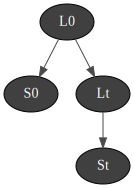

In [12]:
# preview model
gnb.showBN(dbn)

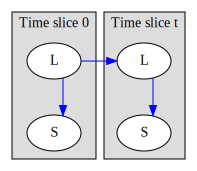

In [13]:
# show time slices
gdyn.showTimeSlices(dbn)

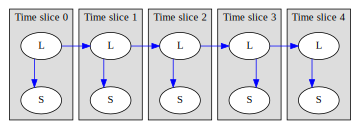

In [14]:
# show propagated model
T = 5 # seconds
ext_dbn = gdyn.unroll2TBN(dbn, T)
gdyn.showTimeSlices(ext_dbn, size=str(T))

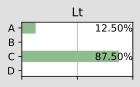

In [15]:
# compute posterior: P(L|S) after 1 update
gnb.showPosterior(dbn, target='Lt', evs={'St': 'C'})

Available evidence: {}
Most likely location...


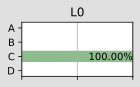

Available evidence: {'S1': 'C'}
Most likely location...


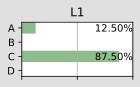

Available evidence: {}
Most likely location...


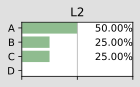

Available evidence: {'S3': 'C'}
Most likely location...


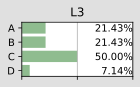

Available evidence: {}
Most likely location...


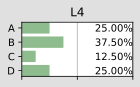

In [16]:
# show posterior changing over time
for i in range(T):
    # conditional evidence
    if i % 2 == 1:
        # sensor returns C every other second
        evidence = {'S{}'.format(i): 'C'}
    else:
        # no sensor return
        evidence = {}
        
    print('Available evidence: {}'.format(evidence))
    print('Most likely location...')
    gnb.showPosterior(ext_dbn, target='L{}'.format(i), evs=evidence)

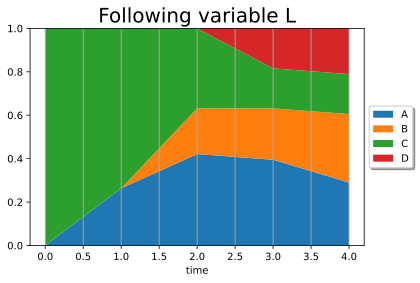

In [17]:
# show evolution of posteriors over T with set evidence
gdyn.plotFollow(['L'], dbn, T=T, evs={'S1': 'C', 'S3': 'D'})